In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

import yfinance as yf

from arch.compat.numba import jit

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

from enum import Enum

In [2]:
def raw_adj_close_prices(ticker: str, date_from: str, date_to: str):
    prices = yf.download(ticker, date_from, date_to)
    prices.index = prices.index.to_period(freq='d')
    return prices['Adj Close']

In [3]:
def raw_adj_close_log_returns(prices: pd.Series):
    return np.log(prices).diff().fillna(0)

In [4]:
def beta(market: pd.Series, single_stock: pd.Series, lag: int = 252):
    return market.cov(single_stock, lag) / market.std(ddof=lag)

In [5]:
@jit
def arch_filtered_series(returns: pd.Series,
                         dist: str = 'Normal',
                         mean: str = 'HARX',
                         vol: str = 'Garch',
                         lag: int = 200,
                         p: int = 1,
                         o: int = 0,
                         q: int = 1,
                         forecast_horizon: int = 30):
    scaling_const = 10.0 / returns.std()

    model = arch_model(scaling_const * returns,
                       mean=mean, lags=lag, # mean = Constant, ARX, HARX + the number of lags
                       vol=vol, p=p, o=o, q=q, # vol = Garch, EGARCH, HARCH + the number of lags
                       dist=dist) # dist = Normal, t, skewstudent, ged

    res = model.fit(update_freq=0, disp='off')
    stand_residuals = res.resid / res.conditional_volatility
    forecast = res.forecast(horizon=forecast_horizon)
    means = pd.Series(forecast.mean.tail(1).to_numpy()[0]) / scaling_const
    vars = pd.Series(forecast.variance.tail(1).to_numpy()[0]) / (scaling_const ** 2)
    return stand_residuals, means, vars # TODO/FIXME something is not clear here, see univariate_risk_management.ipynb

In [ ]:
@jit
def get_filtered_data(nmkt_rets_df):
    net_market_returns_f = {}
    means = {}
    varis = {}
    for ticker, net_rets in nmkt_rets_df.iteritems():
        fltr_res, fcst_means, fcst_vars = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS)
        net_market_returns_f[ticker] = fltr_res[200:]
        means[ticker] = fcst_means
        varis[ticker] = fcst_vars

    nmkt_retsf_df = pd.DataFrame(net_market_returns_f, columns=tickers)
    means_df = pd.DataFrame(means, columns=tickers)
    vars_df = pd.DataFrame(varis, columns=tickers)
    return (nmkt_retsf_df, means_df, vars_df)

In [ ]:
def remove_row_and_column(matrix: np.array, index: int):
    tmp = np.delete(matrix, (index), axis=0)
    return np.delete(tmp, (index), axis=1)

In [ ]:
def calc_alphas(real_returns: pd.DataFrame, corr_matrix: pd.DataFrame, means: pd.DataFrame, varis: pd.DataFrame):
    alphas = {}
    for i in range(0, len(tickers)):
        ticker = tickers[i]
        r_j_j = remove_row_and_column(corr_matrix.to_numpy(), i)
        inv_r_j_j = np.linalg.inv(r_j_j)
        mu_j = np.delete(means.to_numpy(), i)
        sigma_j = np.delete(varis.to_numpy(), i)
        rets = np.delete(real_returns.to_numpy(), i)
        v = (rets - mu_j) / sigma_j
        corr_v = np.delete(corr_matrix[ticker].to_numpy(), i)
        mu = means[ticker] + varis[ticker] * corr_v.dot(inv_r_j_j).dot(v)
        alphas[ticker] = alpha(mu, real_returns[ticker])
    return pd.DataFrame(alphas, columns=tickers)

In [ ]:
def alpha(mu, real_return):
    return 2 * mu - real_return

In [2]:
class BetaType(Enum):
    NO = 1
    RAW = 2
    RETURNS = 3
    FILTERED = 4

In [ ]:
DATE_FROM = '2015-01-01'
DATE_TO = '2017-12-31'
tickers = ['TSLA', 'AAPL', 'IBM', 'AMZN', 'MMM',
           'ABMD', 'ACN', 'APD', 'GOOGL', 'BLK']

%%

In [3]:
BETA_TYPE = BetaType.NO
BETA_LAG = 252
GARCH_LAG = 200
CORRELATION_MATRIX_LAG = 200
GARCH_REFIT_DELAY_DAYS = 30

In [8]:
spy_p = raw_adj_close_prices('SPY', DATE_FROM, DATE_TO)

raw_prices = {}
for ticker in tickers:
    raw_prices[ticker] = raw_adj_close_prices(ticker, DATE_FROM, DATE_TO)
rp_df = pd.DataFrame(raw_prices, columns=tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
rp_df.tail(1)

,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK
Date,,,,,,,,,,
2017-12-29,62.27,40.783367,135.013367,1169.469971,215.700958,187.410004,146.729187,154.349213,1053.400024,476.534546


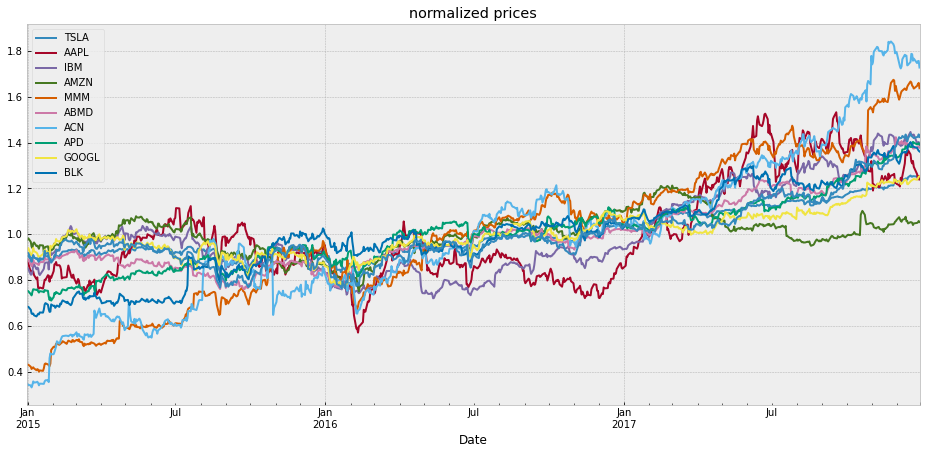

In [10]:
plt.figure(figsize=(16,7))
(spy_p / spy_p.mean()).plot()
for _, data in rp_df.iteritems():
    (data / data.mean()).plot()
plt.title("normalized prices")
plt.legend(tickers)
plt.show()

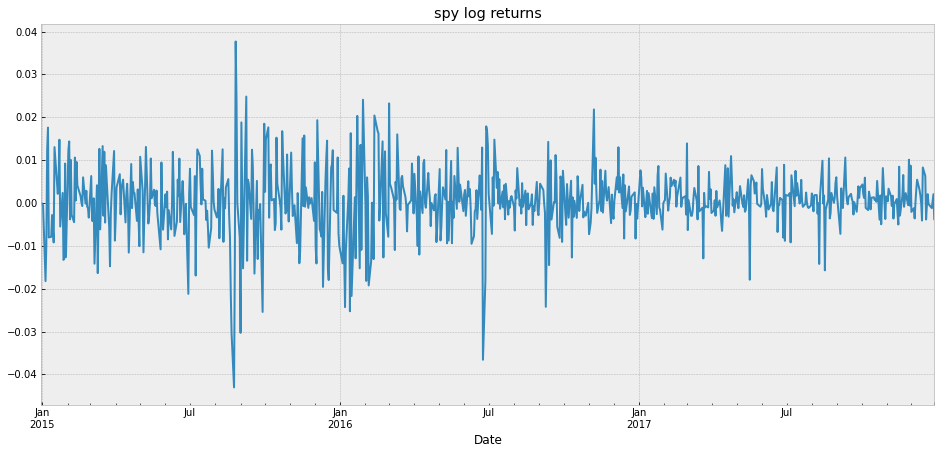

In [11]:
spy = raw_adj_close_log_returns(spy_p)
plt.figure(figsize=(16,7))
spy.plot()
plt.title("spy log returns")
plt.show()

C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


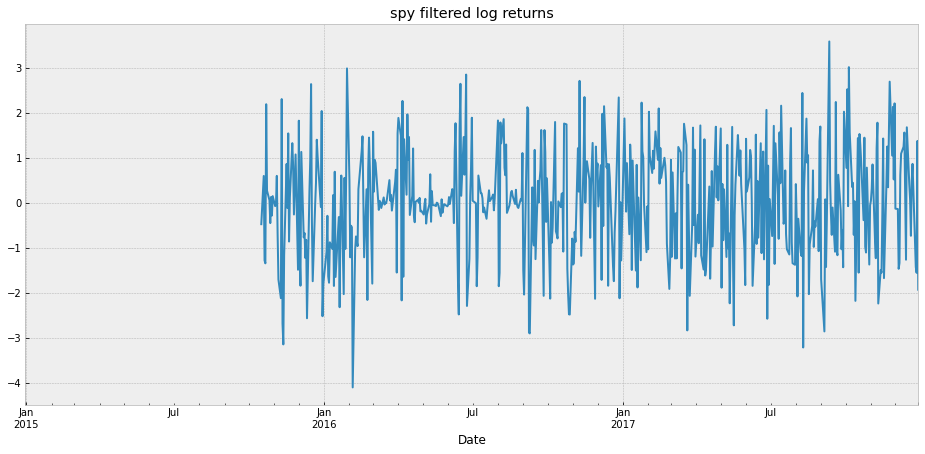

In [12]:
spyf, spy_means, spy_vars = arch_filtered_series(spy, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS)
plt.figure(figsize=(16,7))
spyf.plot()
plt.title("spy filtered log returns")
plt.show()

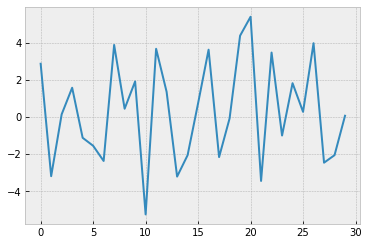

In [13]:
spy_means.plot()
plt.show()

<Figure size 1152x504 with 0 Axes>

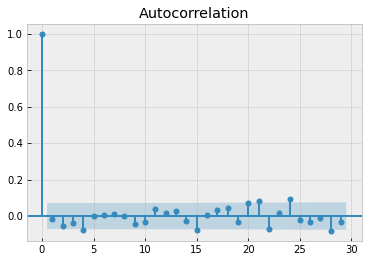

In [14]:
plt.figure(figsize=(16,7))
plot_acf(spy)
plt.show()


<Figure size 1152x504 with 0 Axes>

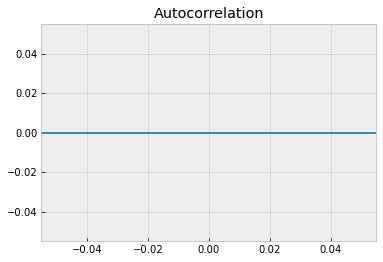

In [15]:
plt.figure(figsize=(16,7))
plot_acf(spyf)
plt.show()

In [16]:
res = spy_p.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spy.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spyf.dropna().values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.354182
p-value: 0.979698
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -15.920002
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -23.271459
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


In [4]:
mkt_returns = {}
for ticker, data in rp_df.iteritems():
    mkt_returns[ticker] = raw_adj_close_log_returns(data)

NameError: name 'rp_df' is not defined

In [6]:
%%time
betas = {}
if BETA_TYPE == BetaType.NO:
    for ticker in tickers:
        betas[ticker] = 0
elif BETA_TYPE == BetaType.RAW:
    for ticker, data in raw_prices.items():
        betas[ticker] = beta(spy_p, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.RETURNS:
    for ticker, data in mkt_returns.items():
        betas[ticker] = beta(spy, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.FILTERED:
    filtered_returns = {}
    for ticker, net_rets in mkt_returns.items():
        fltr_res, _, _ = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS)
        filtered_returns[ticker] = fltr_res[200:]
    for ticker, data in filtered_returns.items():
        betas[ticker] = beta(spyf, data, lag=BETA_LAG)
betas

NameError: name 'tickers' is not defined

In [ ]:
net_market_returns = {}
for ticker, data in mkt_returns.items():
    net_market_returns[ticker] = data - spy * betas[ticker]
    
nmkt_rets_df = pd.DataFrame(net_market_returns, columns=tickers)
nmkt_rets_df



In [ ]:
%%time
today = 200
nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[today - 200: today])#fixme check

In [23]:
corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)

,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK
TSLA,1.000000,0.081718,0.100099,0.144428,-0.003721,0.142468,0.154991,0.061008,0.132095,0.063481
AAPL,0.081718,1.000000,0.066202,0.208924,0.136845,0.199611,0.142053,0.113888,0.260736,0.132221
IBM,0.100099,0.066202,1.000000,0.047005,0.193701,0.037069,0.262908,0.162269,0.108127,0.200104
AMZN,0.144428,0.208924,0.047005,1.000000,0.082346,0.076838,0.208302,0.083842,0.255049,0.051862
MMM,-0.003721,0.136845,0.193701,0.082346,1.000000,0.087019,0.198481,0.230769,0.139962,0.197443
ABMD,0.142468,0.199611,0.037069,0.076838,0.087019,1.000000,0.153819,0.064253,0.059476,0.124007
ACN,0.154991,0.142053,0.262908,0.208302,0.198481,0.153819,1.000000,0.260082,0.263192,0.274706
APD,0.061008,0.113888,0.162269,0.083842,0.230769,0.064253,0.260082,1.000000,0.091813,0.201072
GOOGL,0.132095,0.260736,0.108127,0.255049,0.139962,0.059476,0.263192,0.091813,1.000000,0.125439
BLK,0.063481,0.132221,0.200104,0.051862,0.197443,0.124007,0.274706,0.201072,0.125439,1.000000


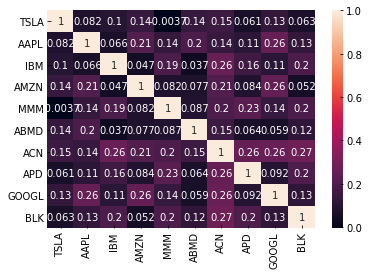

In [24]:
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [118]:
alphas = calc_alphas(nmkt_rets_df[today + 1], corr_matrix, means_df.iloc[0], vars_df.iloc[0])

In [127]:
normalized_alphas = (alphas / alphas.to_numpy().sum())

,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK
Date,,,,,,,,,,
2017-12-29,-0.03136,-0.051154,0.54179,-0.146512,0.321646,0.321717,0.233676,-0.045767,0.041872,-0.185909


In [8]:
def trade(alphas):
    pass

In [9]:
last_refit_date = 200
while last_refit_date < len(raw_prices):
    nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[: last_refit_date])#fixme check
    corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)
    for offset in range(0, GARCH_REFIT_DELAY_DAYS):
        today = last_refit_date + offset
        alphas = calc_alphas(nmkt_rets_df[today + 1], corr_matrix, means_df.iloc[offset], vars_df.iloc[offset])
        normalized_alphas = (alphas / alphas.to_numpy().sum())
        trade(normalized_alphas)
    last_refit_date = last_refit_date + GARCH_REFIT_DELAY_DAYS

NameError: name 'raw_prices' is not defined